In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [47]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [50]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [51]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [54]:
# Find the most recent date in the data set.
date_list = []
for row in session.query(measurement.date).all():
    date_value = row[0]
    date_list.append(date_value)

most_recent_date = max(date_list, key=lambda x: x)
most_recent_date

'2017-08-23'

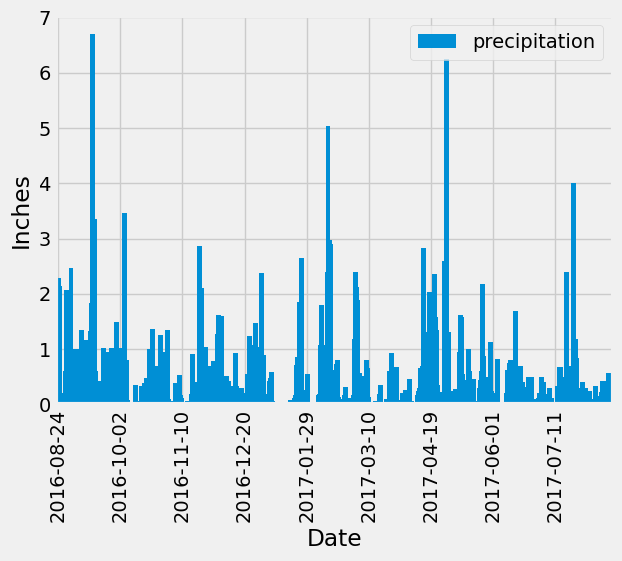

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_format = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_from_last_date = most_recent_date_format + timedelta(days=-365)
result = one_year_from_last_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > result).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_scores, columns=['date', 'prcp'])

# Sort the dataframe by date
sorted_df = df.sort_values('date', ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
y='prcp'
x='date'
df.plot(x='date',y='prcp', kind='bar',width=20)
num_xticks = 10
locator = ticker.MaxNLocator(num_xticks)
plt.gca().xaxis.set_major_locator(locator)
plt.xlabel('Date')
plt.ylabel('Inches')
leg = plt.legend(loc='upper right')
leg.get_texts()[0].set_text('precipitation')
plt.show()


In [56]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [57]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

print(total_stations)

9


In [58]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station,func.count(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.tobs).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
most_active_station_id = most_active_stations[0][0]
most_active_stations = session.query(measurement.station, func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station_id).\
    group_by(measurement.station).all()

most_active_stations

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

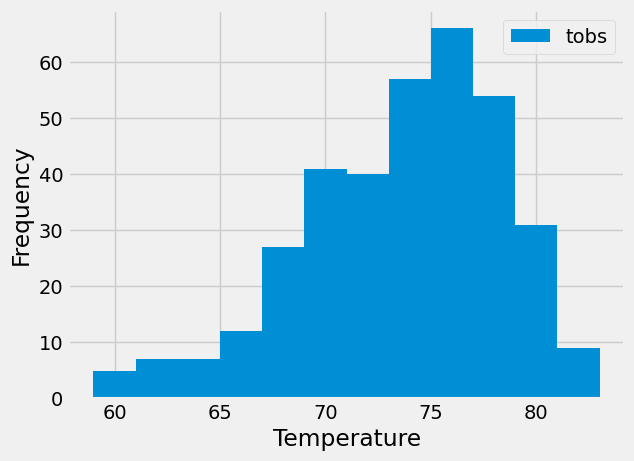

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the data set
date_list_most_active_station = []

date_most_active_station = session.query(measurement.date).\
filter(measurement.station == most_active_station_id).all()

for row in date_most_active_station:
    date_value = row[0]
    date_list_most_active_station.append(date_value)

most_recent_date = max(date_list_most_active_station, key=lambda x: x)
most_recent_date

# Calculate the date one year from the last date in data set
most_recent_date_format = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_from_last_date = most_recent_date_format + timedelta(days=-365)
result = one_year_from_last_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
temperature_observation = session.query(measurement.station, measurement.tobs).\
    filter(measurement.date > result, measurement.station == most_active_station_id).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(temperature_observation, columns=['station', 'tobs'])

# Plot a histogram
plot = df['tobs']
plt.hist(plot,label='tobs',bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [61]:
# Close Session
session.close()